In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import linalg
from datetime import datetime, timedelta
import scipy.optimize as optimization
from scipy.integrate import odeint
from scipy.stats import poisson
from ddeint import ddeint

In [2]:
data=pd.read_csv("./italy_data_Jan2021.csv",low_memory=False)
dataframe=pd.DataFrame(data)
dataframe

,icu,daily_case,total_recover,total_death,total_case,date
0,26,221,1,7,229,2/24/20
1,35,93,1,10,322,2/25/20
2,36,78,3,12,400,2/26/20
3,56,250,45,17,650,2/27/20
4,64,238,46,21,888,2/28/20
...,...,...,...,...,...,...
318,2587,18020,1572015,77291,2220361,1/7/21
319,2587,17533,1589590,77911,2237890,1/8/21
320,2593,19978,1606630,78394,2257866,1/9/21
321,2615,18627,1617804,78755,2276491,1/10/21


In [3]:
# Use 7-day rolling window to calibrate the daily new cases #
calib_daily_case=[]
for i in range(0,6):
    calib_daily_case.append(dataframe['daily_case'][i])
for i in range(6,323):
    res = np.mean(dataframe['daily_case'][i-6:i])
    calib_daily_case.append(res)

In [4]:
# Define the calibrated daily case data as the inflow function #

def inflowfunc(t):
    if t<0:
        return 0
    if t>=0:
        return calib_daily_case[np.floor(t).astype(int)]

In [5]:
DDEtime=np.linspace(0,312,313)
PC0=26
PM0=103
R0=1
gammapc=0.1
gammapm=0.125
mupm=0
eta=1
K=10000
pc=0.1
xi=-math.log(1-pc)
tau=14
lamda=1/40
cumdeath=dataframe['total_death'][312]
epsilon=0.1
f=0.1
gammat=1/(1/gammapc-1)
mut=f*gammat/(1-f)
pd=0.1
alpha=-math.log(1-pd)
omega=alpha

In [6]:
def pfunc(t):
    if 0<=t<=209:
        return 0.03652877
    if t>209:
        return 0.00477068

def mupcfunc(t):
    if 0<=t<=95:
        return 0.2423
    if 95<t<=209:
        return 0.
    if t>209:
        return 0.1692

In [7]:
def D1func(t):
    return 0

In [60]:
startday = 37
    
def epsilonfunc(t):
    if 0<=t<=startday:
        return 0.
    if t>startday:
        return epsilon
    
def sigmafunc(t):
    if 0<=t<=startday:
        return xi
    if t>startday:
        return 1/14

def DDEmodel(Y,t):
    PC,PM,TT,RR,D1,D0,DM,BB=Y(t)
    PCd,PMd,TTd,RRd,D1d,D0d,DMd,BBd=Y(t-tau)
    return np.array([pfunc(t)*PM-(mupcfunc(t)+gammapc)*PC-eta*BB*PC/(BB+K), inflowfunc(t)-(mupm+gammapm+pfunc(t))*PM, 
                    eta*BB*PC/(BB+K)-(mut+gammat)*TT, gammapm*PM-sigmafunc(t)*RR,
                    epsilonfunc(t)*sigmafunc(t)*RR-(alpha+xi)*D1, alpha*(D1+DM)-xi*D0-alpha*math.exp(-xi*tau)*(D1d+DMd),
                    alpha*math.exp(-xi*tau)*(D1d+DMd)-(alpha+xi)*DM, omega*(D1+DM)-eta*BB*PC/(BB+K)-lamda*BB])

g = lambda t : np.array([PC0,PM0,0, R0, D1func(t),0,0,0])
DDEsolday37=ddeint(DDEmodel,g,DDEtime)

In [73]:
max(DDEsolday37[:100,4]+DDEsolday37[:100,6])*omega

156.78645487407488

In [61]:
startday = 99

def epsilonfunc(t):
    if 0<=t<=startday:
        return 0.
    if t>startday:
        return epsilon

def sigmafunc(t):
    if 0<=t<=startday:
        return xi
    if t>startday:
        return 1/14
    
def DDEmodel(Y,t):
    PC,PM,TT,RR,D1,D0,DM,BB=Y(t)
    PCd,PMd,TTd,RRd,D1d,D0d,DMd,BBd=Y(t-tau)
    return np.array([pfunc(t)*PM-(mupcfunc(t)+gammapc)*PC-eta*BB*PC/(BB+K), inflowfunc(t)-(mupm+gammapm+pfunc(t))*PM, 
                    eta*BB*PC/(BB+K)-(mut+gammat)*TT, gammapm*PM-sigmafunc(t)*RR,
                    epsilonfunc(t)*sigmafunc(t)*RR-(alpha+xi)*D1, alpha*(D1+DM)-xi*D0-alpha*math.exp(-xi*tau)*(D1d+DMd),
                    alpha*math.exp(-xi*tau)*(D1d+DMd)-(alpha+xi)*DM, omega*(D1+DM)-eta*BB*PC/(BB+K)-lamda*BB])

g = lambda t : np.array([PC0,PM0,0, R0, D1func(t),0,0,0])
DDEsolday98=ddeint(DDEmodel,g,DDEtime)

In [8]:
startday = 160

def epsilonfunc(t):
    if 0<=t<=startday:
        return 0.
    if t>startday:
        return epsilon
    
def sigmafunc(t):
    if 0<=t<=startday:
        return xi
    if t>startday:
        return 1/14

def DDEmodel(Y,t):
    PC,PM,TT,RR,D1,D0,DM,BB=Y(t)
    PCd,PMd,TTd,RRd,D1d,D0d,DMd,BBd=Y(t-tau)
    return np.array([pfunc(t)*PM-(mupcfunc(t)+gammapc)*PC-eta*BB*PC/(BB+K), inflowfunc(t)-(mupm+gammapm+pfunc(t))*PM, 
                    eta*BB*PC/(BB+K)-(mut+gammat)*TT, gammapm*PM-sigmafunc(t)*RR,
                    epsilonfunc(t)*sigmafunc(t)*RR-(alpha+xi)*D1, alpha*(D1+DM)-xi*D0-alpha*math.exp(-xi*tau)*(D1d+DMd),
                    alpha*math.exp(-xi*tau)*(D1d+DMd)-(alpha+xi)*DM, omega*(D1+DM)-eta*BB*PC/(BB+K)-lamda*BB])

g = lambda t : np.array([PC0,PM0,0, R0, D1func(t),0,0,0])
DDEsolday159=ddeint(DDEmodel,g,DDEtime)

In [63]:
startday = 221

def epsilonfunc(t):
    if 0<=t<=startday:
        return 0.
    if t>startday:
        return epsilon
    
def sigmafunc(t):
    if 0<=t<=startday:
        return xi
    if t>startday:
        return 1/14

def DDEmodel(Y,t):
    PC,PM,TT,RR,D1,D0,DM,BB=Y(t)
    PCd,PMd,TTd,RRd,D1d,D0d,DMd,BBd=Y(t-tau)
    return np.array([pfunc(t)*PM-(mupcfunc(t)+gammapc)*PC-eta*BB*PC/(BB+K), inflowfunc(t)-(mupm+gammapm+pfunc(t))*PM, 
                    eta*BB*PC/(BB+K)-(mut+gammat)*TT, gammapm*PM-sigmafunc(t)*RR,
                    epsilonfunc(t)*sigmafunc(t)*RR-(alpha+xi)*D1, alpha*(D1+DM)-xi*D0-alpha*math.exp(-xi*tau)*(D1d+DMd),
                    alpha*math.exp(-xi*tau)*(D1d+DMd)-(alpha+xi)*DM, omega*(D1+DM)-eta*BB*PC/(BB+K)-lamda*BB])

g = lambda t : np.array([PC0,PM0,0, R0, D1func(t),0,0,0])
DDEsolday221=ddeint(DDEmodel,g,DDEtime)

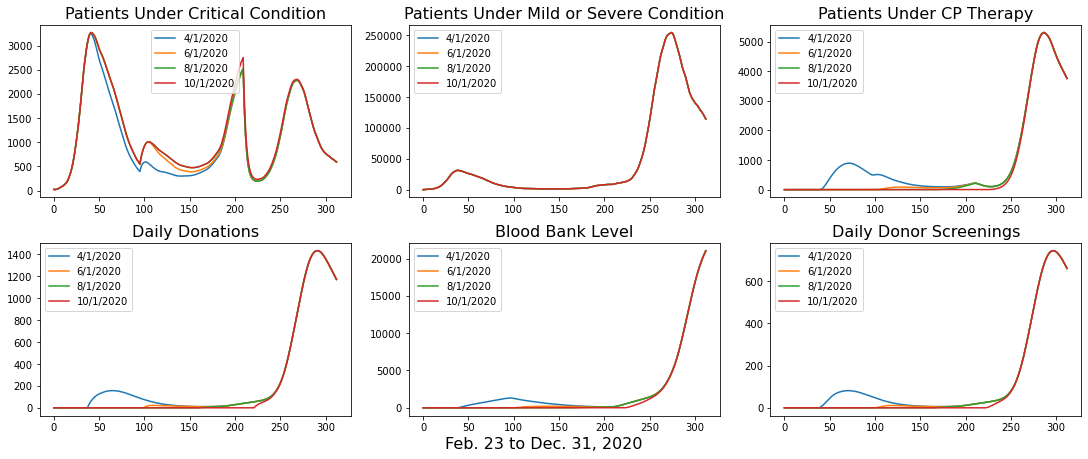

In [64]:
fig, axs = plt.subplots(2,3,gridspec_kw={'hspace': 0.1, 'wspace': 0.1},constrained_layout=True,figsize=(15, 6))
axs[0,0].plot(DDEtime, DDEsolday37[:,0],label='4/1/2020')
axs[0,0].plot(DDEtime, DDEsolday98[:,0],label='6/1/2020')
axs[0,0].plot(DDEtime, DDEsolday159[:,0],label='8/1/2020')
axs[0,0].plot(DDEtime, DDEsolday221[:,0],label='10/1/2020')
axs[0,0].legend()
axs[0,0].set_title('Patients Under Critical Condition',fontsize=16)
axs[0,1].plot(DDEtime, DDEsolday37[:,1],label='4/1/2020')
axs[0,1].plot(DDEtime, DDEsolday98[:,1],label='6/1/2020')
axs[0,1].plot(DDEtime, DDEsolday159[:,1],label='8/1/2020')
axs[0,1].plot(DDEtime, DDEsolday221[:,1],label='10/1/2020')
axs[0,1].legend()
axs[0,1].set_title('Patients Under Mild or Severe Condition',fontsize=16)
axs[0,2].plot(DDEtime, DDEsolday37[:,2],label='4/1/2020')
axs[0,2].plot(DDEtime, DDEsolday98[:,2],label='6/1/2020')
axs[0,2].plot(DDEtime, DDEsolday159[:,2],label='8/1/2020')
axs[0,2].plot(DDEtime, DDEsolday221[:,2],label='10/1/2020')
axs[0,2].legend()
axs[0,2].set_title('Patients Under CP Therapy',fontsize=16)
axs[1,0].plot(DDEtime, omega*(DDEsolday37[:,4]+DDEsolday37[:,6]),label='4/1/2020')
axs[1,0].plot(DDEtime, omega*(DDEsolday98[:,4]+DDEsolday98[:,6]),label='6/1/2020')
axs[1,0].plot(DDEtime, omega*(DDEsolday159[:,4]+DDEsolday159[:,6]),label='8/1/2020')
axs[1,0].plot(DDEtime, omega*(DDEsolday221[:,4]+DDEsolday221[:,6]),label='10/1/2020')
axs[1,0].legend()
axs[1,0].set_title('Daily Donations',fontsize=16)
axs[1,1].plot(DDEtime, DDEsolday37[:,7],label='4/1/2020')
axs[1,1].plot(DDEtime, DDEsolday98[:,7],label='6/1/2020')
axs[1,1].plot(DDEtime, DDEsolday159[:,7],label='8/1/2020')
axs[1,1].plot(DDEtime, DDEsolday221[:,7],label='10/1/2020')
axs[1,1].legend()
axs[1,1].set_title('Blood Bank Level',fontsize=16)
axs[1,2].plot(DDEtime, 1/14*DDEsolday37[:,5],label='4/1/2020')
axs[1,2].plot(DDEtime, 1/14*DDEsolday98[:,5],label='6/1/2020')
axs[1,2].plot(DDEtime, 1/14*DDEsolday159[:,5],label='8/1/2020')
axs[1,2].plot(DDEtime, 1/14*DDEsolday221[:,5],label='10/1/2020')
axs[1,2].legend()
axs[1,2].set_title('Daily Donor Screenings',fontsize=16)
fig.text(0.5, -0.02, 'Feb. 23 to Dec. 31, 2020', ha='center', va='center',fontsize=16)
#fig.text(0.8, -0.02, 'Days Since Feb. 23rd, 2020', ha='center', va='center')
fig.savefig('timeseries_timing.pdf',dpi=300, bbox_inches = "tight")

In [9]:
timelist=np.array((38,68,99,129,160,191,221))

In [66]:
deathlist=[]
maxlist=[]

for i in timelist:
    startday = i
    def epsilonfunc(t):
        if 0<=t<=startday:
            return 0.
        if t>startday:
            return epsilon
    
    def sigmafunc(t):
        if 0<=t<=startday:
            return xi
        if t>startday:
            return 1/14
        
    def DDEmodel(Y,t):
        PC,PM,TT,RR,D1,D0,DM,BB,DD=Y(t)
        PCd,PMd,TTd,RRd,D1d,D0d,DMd,BBd,DDd=Y(t-tau)
        return np.array([pfunc(t)*PM-(mupcfunc(t)+gammapc)*PC-eta*BB*PC/(BB+K), inflowfunc(t)-(mupm+gammapm+pfunc(t))*PM, 
                    eta*BB*PC/(BB+K)-(mut+gammat)*TT, gammapm*PM-sigmafunc(t)*RR,
                    epsilonfunc(t)*sigmafunc(t)*RR-(alpha+xi)*D1, alpha*(D1+DM)-xi*D0-alpha*math.exp(-xi*tau)*(D1d+DMd),
                    alpha*math.exp(-xi*tau)*(D1d+DMd)-(alpha+xi)*DM, omega*(D1+DM)-eta*BB*PC/(BB+K)-lamda*BB,
                    mupcfunc(t)*PC+mupm*PM+mut*TT])
    g = lambda t : np.array([PC0,PM0,0, R0, D1func(t),0,0,0,7])
    DDEsol=ddeint(DDEmodel,g,DDEtime)
    deathlist.append(cumdeath-DDEsol[-1,8])
    maxlist.append(max(DDEsol[:,4]+DDEsol[:,6])*omega)

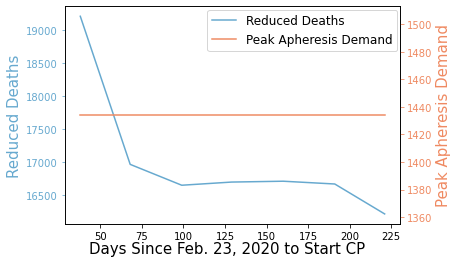

In [67]:
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(timelist, deathlist, c='#67a9cf',label='Reduced Deaths')
#ax1.set_xlim(1,20)
fig1.text(0.5, 0.04, 'Days Since Feb. 23, 2020 to Start CP',ha='center', va='center', fontsize=15)
ax1.set_ylabel('Reduced Deaths', color='#67a9cf',fontsize=15)
ax1.tick_params('y', colors='#67a9cf')
ax2.plot(timelist, np.floor(maxlist), c='#ef8a62',label='Peak Apheresis Demand')
ax2.set_ylabel('Peak Apheresis Demand', color='#ef8a62',fontsize=15)
ax2.tick_params('y', colors='#ef8a62')
fig1.legend(loc='upper center',bbox_to_anchor=(0.7,0.9),fontsize=12)
plt.savefig('timing_apheresis.pdf',dpi=300,bbox_inches = "tight")

In [10]:
EFFlist=np.array((99,95,90,85,80,75,70,65,60,55,50))
CFRlist=np.array((1,5,10,15,20,25,30,35,40,45,50))

In [11]:
fulldeath=[]

for i in timelist:
    subdeath=[]
    
    startday = i
    def epsilonfunc(t):
        if 0<=t<=startday:
            return 0.
        if t>startday:
            return epsilon
    
    def sigmafunc(t):
        if 0<=t<=startday:
            return xi
        if t>startday:
            return 1/14
    
    for j in CFRlist:
        f=0.01*j
        gammat=1/(1/gammapc-1)
        mut=f*gammat/(1-f)
        
        def DDEmodel(Y,t):
            PC,PM,TT,RR,D1,D0,DM,BB,DD=Y(t)
            PCd,PMd,TTd,RRd,D1d,D0d,DMd,BBd,DDd=Y(t-tau)
            return np.array([pfunc(t)*PM-(mupcfunc(t)+gammapc)*PC-eta*BB*PC/(BB+K), inflowfunc(t)-(mupm+gammapm+pfunc(t))*PM, 
                    eta*BB*PC/(BB+K)-(mut+gammat)*TT, gammapm*PM-sigmafunc(t)*RR,
                    epsilonfunc(t)*sigmafunc(t)*RR-(alpha+xi)*D1, alpha*(D1+DM)-xi*D0-alpha*math.exp(-xi*tau)*(D1d+DMd),
                    alpha*math.exp(-xi*tau)*(D1d+DMd)-(alpha+xi)*DM, omega*(D1+DM)-eta*BB*PC/(BB+K)-lamda*BB,
                    mupcfunc(t)*PC+mupm*PM+mut*TT])
        g = lambda t : np.array([PC0,PM0,0, R0, D1func(t),0,0,0,7])
        DDEsol=ddeint(DDEmodel,g,DDEtime)
        subdeath.append(cumdeath-DDEsol[-1,8])
    fulldeath.append(subdeath)  

Text(0.5, 1.0, 'Reduced Deaths by the End of Year 2020')

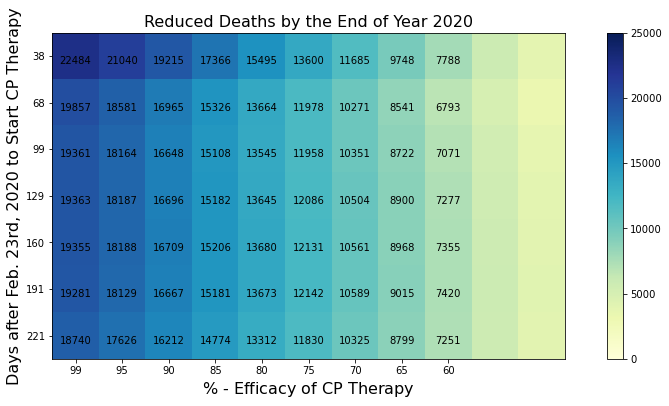

In [13]:
fig, ax = plt.subplots(figsize=(15,6))
plt.rc('font', size=10)
plt.imshow(fulldeath,cmap='YlGnBu',vmin=0,vmax=25000)
plt.colorbar()
ax.set_yticks(np.arange(7))
ax.set_xticks(np.arange(9))
ax.set_yticklabels(timelist)
ax.set_xticklabels(EFFlist)
plt.ylabel('Days after Feb. 23rd, 2020 to Start CP Therapy',fontsize=16)
plt.xlabel('$\%$ - Efficacy of CP Therapy',fontsize=16)
for i in range(0,9):
    for j in range(0,7):
        text = ax.text(i, j, int(fulldeath[j][i]),
                      ha="center", va="top", color="black")
plt.title('Reduced Deaths by the End of Year 2020',fontsize=16)